In [1]:
import sys
sys.path.append('../')

from src.chainables import Chainable, ChainableObject, ChainableFunction, TypeSafeChainableFunction
from typing import List, Optional, Any, Union
from pprint import pprint

{'de': 'Spannungssignal 1', 'en': 'Voltage signal 1'}
{'de': 'Spannungssignal 2', 'en': 'Voltage signal 2'}
data.signal.[0].signal
data.signal.[1].signal
meta.signal.[0].label.de
meta.signal.[1].label.de
meta.signal.[0].column_labels.de
meta.signal.[0].column_units


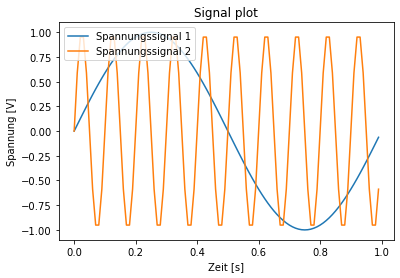

In [35]:
from pydantic import Field
import numpy as np

class Signals:
    pass
Chainable.Signal = Signals()

class SinusVoltageGenerator(TypeSafeChainableFunction):
    class Param(TypeSafeChainableFunction.Param):
        data_name: str
        label: Optional[dict[str, str]] = {'de':"Spannungssignal", 'en':"Voltage signal"}
        frequency_Hz : Optional[float] = 1.0
        amplitude_V: Optional[float] = 1.0
        sample_duration_s: Optional[float] = 1.0
        sampling_frequency_Hz: Optional[float] = 100.0
        
    class Data(TypeSafeChainableFunction.Data):
        signal: np.ndarray# = Field(default_factory=lambda: np.zeros(0,0))
        
    class Meta(TypeSafeChainableFunction.Meta):
        name: str
        label: dict[str, str]
        column_labels: dict[str, List[str]]
        column_quantities: List[str]
        column_units: List[str]
    
    def __init__(self):
        super(__class__, self).__init__(name="sinus_voltage_generator", uuid="f4e25e06-5307-464c-8b07-c3f3033a798d", param_class=__class__.Param, data_class=__class__.Data, meta_class=__class__.Meta)

    def func(self, param):
        print(param.label)
        sample_interval_s = param.sample_duration_s/param.sampling_frequency_Hz
        x = np.arange(0, param.sample_duration_s, sample_interval_s)
        y = np.sin(2 * np.pi * param.frequency_Hz * x)
        signal = np.vstack((x, y)).T
        super().store('signal', 
                      {'signal': signal}, 
                      {'name': param.data_name, 
                       'label': param.label, 
                       'column_labels': {'de': ["Zeit", "Spannung"], 'en': ["Time", "Voltage"]},
                       'column_quantities': ["qudt:Time", "qudt:Voltage"], 
                       'column_units': ["s", "V"], 
                      }
                     )
Chainable.Signal.sinus_voltage_generator = SinusVoltageGenerator()

import matplotlib
import matplotlib.pyplot as plt 
class SignalPlot(TypeSafeChainableFunction):
    class Param(TypeSafeChainableFunction.Param):
        data_name: str
        signals: Union[np.ndarray, List[np.ndarray]]# = Field(default_factory=lambda: np.zeros(0,0))
        labels: Optional[Union[str, List[str]]] = []
        axis_labels: Optional[Union[str, List[str]]] = []
        axis_units: Optional[Union[str, List[str]]] = []
        title: str = "Signal plot"
        
    class Data(TypeSafeChainableFunction.Data):
        #pass
        figure: matplotlib.figure.Figure
        
    class Meta(TypeSafeChainableFunction.Meta):
        name: str
    
    def __init__(self):
        super(__class__, self).__init__(name="signal_plot", uuid="a21d3dc4-efcb-48eb-a951-85ef0050b3bf", param_class=__class__.Param, data_class=__class__.Data, meta_class=__class__.Meta)

    def func(self, param):
        fig = plt.figure()

        if (type(param.signals) == np.ndarray): param.signals = [param.signals]
        if (type(param.labels) == str): param.labels = [param.labels]
        if (type(param.axis_labels) == str): param.axis_labels = [param.axis_labels]
        if (type(param.axis_units) == str): param.axis_units = [param.axis_units]
        
        for (index,signal) in enumerate(param.signals):
            label = ""
            if len(param.labels) > index: label = param.labels[index]
            plt.plot(signal[:,0], signal[:,1], label=label, figure=fig)
            
        for (index,axis_label) in enumerate(param.axis_labels):
            unit = ""
            if len(param.axis_units) > index: unit = f" [{param.axis_units[index]}]"
            if (index == 0): plt.xlabel(f"{axis_label}{unit}", figure=fig)
            if (index == 1): plt.ylabel(f"{axis_label}{unit}", figure=fig)
            
        plt.title(param.title, figure=fig)
        plt.legend(loc="upper left")
        super().store('plot', 
                      {'figure': fig}, 
                      {'name': param.data_name, 
                      }
                     )
Chainable.Signal.signal_plot = SignalPlot()
        
obj = ChainableObject()
#obj = Chainable.Signal.sinus_voltage_generator.apply(obj, {'debug': True, 'data_name': "Test"})

lang = 'de'
obj = obj.apply({
    'func': "Chainable.Signal.sinus_voltage_generator",
    'param': {'debug': False, 'data_name': "signal1", 'frequency_Hz': 1, 'label': {'static': {'de':"Spannungssignal 1", 'en':"Voltage signal 1"}}}
}).apply({
    'func': "Chainable.Signal.sinus_voltage_generator",
    'param': {'debug': False, 'data_name': "signal2", 'frequency_Hz': 10, 'label': {'static': {'de':"Spannungssignal 2", 'en':"Voltage signal 2"}}}
}).apply({
    'func': "Chainable.Signal.signal_plot",
    'param': {'debug': False, 'data_name': "plot1", 
              'signals': {'match': {'meta': {'jsonpath': 'meta.*[?name =~ "signal"]'}}, 'value': {'data': {'jsonpath': 'signal'}}}, #default: traverse to data branch
              'labels': {'match': {'meta': {'jsonpath': 'meta.*[?name =~ "signal"]'}}, 'value': {'meta': {'jsonpath': f'label.{lang}'}}}, #value path relative to match path
              'axis_labels': {'match': {'meta': {'jsonpath': 'meta.*[?name = "signal1"]'}}, 'value': {'meta': {'jsonpath': f'column_labels.{lang}'}}},
              'axis_units': {'match': {'meta': {'jsonpath': 'meta.*[?name = "signal1"]'}}, 'value': {'meta': {'jsonpath': 'column_units'}}},
             }
})      
#pprint(obj.dict())
